In [1]:
import pandas as pd
import seaborn as sns
import keras
from keras.datasets import  mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# initial configuration
batch_size = 128
num_classes = 10
epochs = 12 # 多ければいいってもんじゃない

img_rows, img_cols = 28, 28

In [3]:
df_train = pd.read_csv("Digit_recognizer/train.csv")
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# split df_train to train and evaluation dataset
x_train, x_test, y_train, y_test = train_test_split(
    df_train.loc[:, "pixel0": "pixel783"],
    df_train["label"],
    test_size=0.25, random_state=71)

In [5]:
# convert 1D np.array to 2D np.array  (branch processing according to Tensorflow or Therano)
# (supplement: how to convert dataframe to np.array is "x_train.values")
if K.image_data_format() == 'channels_first':
    x_train = x_train.values.reshape(x_train.shape[0], 1, img_rows, img_cols) # x_train.shape[0] : 60000
    x_test = x_test.values.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [6]:
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train /= 255 # scaling for 255 because the range of x_train is 0~255
x_test /= 255
print('x_train shape:', x_train.shape) # (train sample nums, 28row, 28column, 1channel) 
print(x_train.shape[0], 'train samples') 
print(x_test.shape[0], 'test samples')

x_train shape: (31500, 28, 28, 1)
31500 train samples
10500 test samples


In [7]:
# convert to "one-hot" expression with every label elements 
# e.g. "5"> "[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test =  keras.utils.np_utils.to_categorical(y_test, num_classes)

In [8]:
# CNN structure settings 
"""ref: Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', 
                            data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, 
                            kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                            kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                            kernel_constraint=None, bias_constraint=None)"""
# filters: kernel (or filter) numbers (window size?)
# kernel_size：　kernel size (row, column)

"""Conv>Relu>Conv>Relu>Pooling>Dropout>Flatten(2D>1D)>Affine>Relu>Dropout>Output>Softmax"""
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [9]:
# run learning
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test))

Train on 31500 samples, validate on 10500 samples
Epoch 1/30
31500/31500 [==============================] - 90s - loss: 0.4997 - acc: 0.8427 - val_loss: 0.1838 - val_acc: 0.9462
Epoch 2/30
31500/31500 [==============================] - 98s - loss: 0.1649 - acc: 0.9499 - val_loss: 0.1011 - val_acc: 0.9692
Epoch 3/30
31500/31500 [==============================] - 106s - loss: 0.1167 - acc: 0.9650 - val_loss: 0.0752 - val_acc: 0.9771
Epoch 4/30
31500/31500 [==============================] - 107s - loss: 0.0944 - acc: 0.9714 - val_loss: 0.0617 - val_acc: 0.9802
Epoch 5/30
31500/31500 [==============================] - 101s - loss: 0.0776 - acc: 0.9767 - val_loss: 0.0562 - val_acc: 0.9832
Epoch 6/30
31500/31500 [==============================] - 97s - loss: 0.0708 - acc: 0.9781 - val_loss: 0.0559 - val_acc: 0.9824
Epoch 7/30
31500/31500 [==============================] - 97s - loss: 0.0650 - acc: 0.9800 - val_loss: 0.0499 - val_acc: 0.9849
Epoch 8/30
31500/31500 [===========================

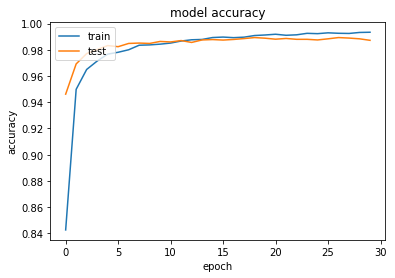

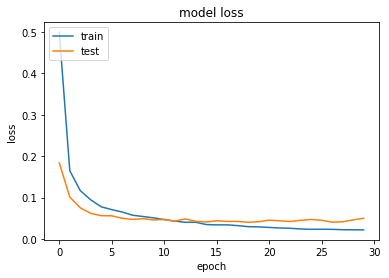

In [10]:
import matplotlib.pyplot as plt
# accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc']) # validation_accuracy (test data)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])# validation_loss (test data)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# generate submission data 
df_submission = pd.read_csv("Digit_recognizer/test.csv")
df_submission

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# convert 1D np.array to 2D np.array  (branch processing according to Tensorflow or Therano)
# (supplement: how to convert dataframe to np.array is "x_train.values")
if K.image_data_format() == 'channels_first':
    x_submission = df_submission.values.reshape(df_submission.shape[0], 1, img_rows, img_cols) # x_train.shape[0] : 60000
    input_shape = (1, img_rows, img_cols)
else:
    x_submission = df_submission.values.reshape(df_submission.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
# prediction
y_submission = model.predict_classes(x_submission, batch_size, verbose=1)

28000/28000 [==============================] - 23s    


In [14]:
y_submission

array([2, 0, 9, ..., 3, 9, 2])

In [15]:
df_yIndTemp = pd.DataFrame(np.arange(1,28001), columns=["ImageId"])
df_yTemp = pd.DataFrame(y_submission, columns=["Label"])
df_submission_set = pd.concat([df_yIndTemp, df_yTemp], axis=1)
df_submission_set

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [16]:
df_submission_set.to_csv("Digit_recognizer/submission.csv",index=False, sep=",")